In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib import rc # 폰트
#한글폰트 적용-----------------------------
from matplotlib import font_manager, rc
plt.rc('font', family='Malgun Gothic')
#-----------------------------------------


from datetime import datetime
import time
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
# datetime.strptime(start_date, '%Y-%m-%d %H:%M:%S')

path = 'C:\\Users\\USER\\'

# 종속변수 difficulty(난이도)

## 데이터 import

In [2]:
#데이터 import
track=pd.read_csv(path+'data\\track.csv')
track_curve=pd.read_csv(path+'data\\track_curve.csv')
track_obstacle=pd.read_csv(path+'data\\track_obstacle.csv')
track_road=pd.read_csv(path+'data\\track_road.csv')
track_shortcut=pd.read_csv(path+'data\\track_shortcut.csv')
track_straight=pd.read_csv(path+'data\\track_straight.csv')
track_trigger=pd.read_csv(path+'data\\track_trigger.csv')
match_indicator=pd.read_csv(path+'api\\match-indicator-extraction.csv', encoding='cp949')
track_curve['all_section']=track_curve['hairpin']+track_curve['acute']+track_curve['obtuse']

In [3]:
#이름 설정 및 데이터 타입 변경
track_straight=pd.concat([track_straight.iloc[:, 0:1], track_straight.iloc[:, 1:].add_prefix('straight_')], axis=1)
track_curve=pd.concat([track_curve.iloc[:, 0:1], track_curve.iloc[:, 1:].add_prefix('curve_')], axis=1)
track_obstacle=pd.concat([track_obstacle.iloc[:, 0:1], track_obstacle.iloc[:, 1:].add_prefix('obstacle_')], axis=1)
track_trigger=pd.concat([track_trigger.iloc[:, 0:1], track_trigger.iloc[:, 1:].add_prefix('trigger_')], axis=1)
track_shortcut=pd.concat([track_shortcut.iloc[:, 0:1], track_shortcut.iloc[:, 1:].add_prefix('shortcut_')], axis=1)
track.rename(columns={'id':'track_id', 'name':'track_name'},inplace=True)
track['date']=pd.to_datetime(track['release_date'])
track['year']=track['date'].dt.year.astype(int)
track['month']=track['date'].dt.month.astype(int)
track.drop(['date', 'release_date'], axis=1, inplace=True)
match_indicator=match_indicator.iloc[:, 1:]

## 데이터 merge

In [4]:
final_df=pd.merge(track, match_indicator, how='left', on='track_id')
final_df=pd.merge(final_df, track_straight, how='left', on='track_id')
final_df=pd.merge(final_df, track_trigger, how='left', on='track_id')
final_df=pd.merge(final_df, track_curve, how='left', on='track_id')
final_df=pd.merge(final_df, track_shortcut, how='left', on='track_id')
final_df=pd.merge(final_df, track_obstacle, how='left', on='track_id')
final_df['sum_straight_curve']=final_df['straight_all_section']+final_df['curve_all_section']
tmp1=final_df.sort_values(by='cnt_match', ascending=False)[:44]
tmp2=final_df.sort_values(by='cnt_match', ascending=False)[44:]
tmp1['track_upper']=1
tmp2['track_upper']=0
final_df=pd.concat([tmp1, tmp2])
final_df.sort_index(inplace=True)
final_df=pd.merge(final_df, track_road, how='left', on='track_id')
final_df.drop('track_id', axis=1, inplace=True)

In [5]:
final_df.head()

,track_name,difficulty,lap,length,direction,theme,year,month,cnt_match,percent_retire,...,shortcut_right,shortcut_acute,shortcut_obtuse,shortcut_special,obstacle_fixed,obstacle_moved,sum_straight_curve,track_upper,fence_exist,mean_road_level
0,트랙 9,2,1,3.5,단선형,해변,2013,8,7067,20.8078,...,0,0,0,0,0,0,18.0,1,0,1
1,코리아 제주 해오름 다운힐,2,1,5.6,단선형,코리아,2021,8,4183,21.5840,...,0,1,0,0,1,1,44.0,1,0,1
2,월드 뉴욕 대질주,3,1,6.9,단선형,월드,2015,12,1085,27.1801,...,0,1,0,0,15,0,59.0,1,1,1
3,월드 리오 다운힐,2,1,5.7,단선형,월드,2015,12,978,22.3251,...,0,1,1,0,8,0,44.5,1,0,2
4,신화 신들의 세계,3,1,6.9,워프형,신화,2018,12,821,19.4186,...,0,0,0,0,0,1,63.0,1,0,1


In [6]:
final_df.describe()

,difficulty,lap,length,year,month,cnt_match,percent_retire,AVG_record,straight_jump,straight_uphill,...,shortcut_right,shortcut_acute,shortcut_obtuse,shortcut_special,obstacle_fixed,obstacle_moved,sum_straight_curve,track_upper,fence_exist,mean_road_level
count,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,...,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000
mean,2.590909,2.261364,7.296591,2012.500000,7.795455,753.215909,27.586106,122979.385492,0.409091,6.204545,...,0.784091,0.534091,0.159091,0.409091,5.113636,0.840909,96.539773,0.500000,0.420455,1.352273
std,1.120718,0.702938,2.293341,5.785436,3.107866,1500.935467,12.823972,49936.491163,1.035423,5.571188,...,1.956121,1.113644,0.842634,0.954558,5.635340,2.164958,29.054173,0.502865,0.496461,0.526095
min,1.000000,1.000000,1.500000,2004.000000,1.000000,29.000000,0.000000,51731.585020,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,0.000000,0.000000,1.000000
25%,2.000000,2.000000,6.000000,2007.750000,6.000000,40.750000,19.943875,95568.672265,0.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,80.000000,0.000000,0.000000,1.000000
50%,2.000000,2.000000,6.900000,2012.500000,7.000000,275.000000,27.093800,113619.425000,0.000000,6.000000,...,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,92.000000,0.500000,0.000000,1.000000
75%,3.000000,3.000000,8.425000,2017.250000,11.000000,825.750000,34.486850,135899.756675,0.000000,8.250000,...,0.000000,0.250000,0.000000,0.000000,6.000000,0.000000,113.000000,1.000000,1.000000,2.000000
max,6.000000,3.000000,17.100000,2022.000000,12.000000,10325.000000,65.104700,373421.855600,4.000000,28.000000,...,12.000000,6.000000,7.000000,4.000000,30.000000,12.000000,211.500000,1.000000,1.000000,3.000000


## 파생변수 추가

In [7]:
# 파생변수 만들기

# 1. 오르막 내리막

final_df['updownhill'] = final_df['straight_uphill'] + final_df['straight_downhill']

# 2. 직선구간 비율 (직선구간 / 전체구간)

final_df['ratio_straight'] = final_df['straight_all_section'] / final_df['sum_straight_curve']

# 2. 곡선구간 비율 (곡선구간 / 전체구간)

final_df['ratio_curve'] = final_df['curve_all_section'] / final_df['sum_straight_curve']

# 3. 헤어핀 비율

final_df['ratio_hairpin'] = final_df['curve_hairpin'] / final_df['curve_all_section']

# 4. 예각 비율

final_df['ratio_acute'] = final_df['curve_acute'] / final_df['curve_all_section']

# 5. 둔각 비율

final_df['ratio_obtuse'] = final_df['curve_obtuse'] / final_df['curve_all_section']

# 6. 직각 지름길 비율

final_df['ratio_shortcut_right'] =  final_df['shortcut_right'] / (final_df['shortcut_right'] + final_df['shortcut_acute'] + final_df['shortcut_obtuse']+ final_df['shortcut_special'])

# 7. 예각 지름길 비율

final_df['ratio_shortcut_acute'] =  final_df['shortcut_acute'] /  (final_df['shortcut_right'] + final_df['shortcut_acute'] + final_df['shortcut_obtuse']+ final_df['shortcut_special'])

# 8. 둔각 지름길 비율

final_df['ratio_shortcut_obtuse'] =  final_df['shortcut_obtuse'] /  (final_df['shortcut_right'] + final_df['shortcut_acute'] + final_df['shortcut_obtuse']+ final_df['shortcut_special'])

# 9. 특수 지름길 비율

final_df['ratio_shortcut_special'] =  final_df['shortcut_special'] /  (final_df['shortcut_right'] + final_df['shortcut_acute'] + final_df['shortcut_obtuse']+ final_df['shortcut_special'])

# 10. 장애물 개수

final_df['obstacle'] = final_df['obstacle_fixed'] + final_df['obstacle_moved']

# 11. 평균 속력

final_df['speed'] = final_df['AVG_record'] / final_df['length']

# 12. 지름길 개수

final_df['shortcut'] = final_df['shortcut_right'] + final_df['shortcut_acute'] + final_df['shortcut_obtuse']+ final_df['shortcut_special']

In [8]:
final_df.isnull().sum()

track_name                  0
difficulty                  0
lap                         0
length                      0
direction                   0
theme                       0
year                        0
month                       0
cnt_match                   0
percent_retire              0
AVG_record                  0
straight_jump               0
straight_uphill             0
straight_downhill           0
straight_all_section        0
trigger_accel               0
trigger_warp                0
trigger_decel               0
trigger_jump                0
curve_hairpin               0
curve_acute                 0
curve_obtuse                0
curve_continuous            0
curve_continuous_acute      0
curve_continuous_obtuse     0
curve_all_section           0
shortcut_right              0
shortcut_acute              0
shortcut_obtuse             0
shortcut_special            0
obstacle_fixed              0
obstacle_moved              0
sum_straight_curve          0
track_uppe

In [9]:
final_df = final_df.fillna(0)

## 왜도 확인
- 왜도가 -2~2사이에 있으면 정규분포를 만족한다고 본다. 
- 정규분포를 만족하지 않는 값은 log를 씌우는 것을 고려해보자.

In [10]:
final_df.skew()

difficulty                 0.970351
lap                       -0.415763
length                     1.587628
year                       0.055575
month                     -0.098579
cnt_match                  4.389513
percent_retire             0.337072
AVG_record                 2.567460
straight_jump              2.410467
straight_uphill            1.394785
straight_downhill          1.159320
straight_all_section       0.225244
trigger_accel              4.418296
trigger_warp               2.867280
trigger_decel              1.210916
trigger_jump               2.714076
curve_hairpin              1.826973
curve_acute                0.900958
curve_obtuse               1.720740
curve_continuous           2.017556
curve_continuous_acute     1.949774
curve_continuous_obtuse    2.543348
curve_all_section          1.967247
shortcut_right             3.459384
shortcut_acute             2.492672
shortcut_obtuse            6.883657
shortcut_special           2.254017
obstacle_fixed             1

## 통계분석 (단순회귀)
* ✨ 의미 : p-value 0.05 미만으로 유의미한 결과

### ✨straight_jump : 점프 구간개수

In [12]:
# 로그o,수정 r제곱 0.036
test = ols('difficulty ~ np.log1p(straight_jump)', data = final_df).fit().summary()
print(test)

                            OLS Regression Results                            
Dep. Variable:             difficulty   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     4.267
Date:                Fri, 25 Nov 2022   Prob (F-statistic):             0.0419
Time:                        01:44:31   Log-Likelihood:                -132.26
No. Observations:                  88   AIC:                             268.5
Df Residuals:                      86   BIC:                             273.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [13]:
# 로그x,수정 r제곱 0.049
test = ols('difficulty ~ straight_jump', data = final_df).fit().summary()
print(test)

                            OLS Regression Results                            
Dep. Variable:             difficulty   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     5.488
Date:                Fri, 25 Nov 2022   Prob (F-statistic):             0.0215
Time:                        01:49:37   Log-Likelihood:                -131.67
No. Observations:                  88   AIC:                             267.3
Df Residuals:                      86   BIC:                             272.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         2.4825      0.125     19.802

### ✨straight_uphill : 오르막길 개수

In [14]:
# 로그x, 수정 r제곱 0.069
test = ols('difficulty ~ straight_uphill', data = final_df).fit().summary()
print(test)

                            OLS Regression Results                            
Dep. Variable:             difficulty   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     7.449
Date:                Fri, 25 Nov 2022   Prob (F-statistic):            0.00770
Time:                        01:49:39   Log-Likelihood:                -130.74
No. Observations:                  88   AIC:                             265.5
Df Residuals:                      86   BIC:                             270.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           2.2385      0.173     

In [15]:
#로그o, r제곱 0.003
test = ols('difficulty ~ np.log1p(straight_uphill)', data = final_df).fit().summary()
print(test)

                            OLS Regression Results                            
Dep. Variable:             difficulty   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.267
Date:                Fri, 25 Nov 2022   Prob (F-statistic):              0.264
Time:                        01:49:43   Log-Likelihood:                -133.75
No. Observations:                  88   AIC:                             271.5
Df Residuals:                      86   BIC:                             276.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

### ✨ straight_downhill: 내리막길 개수

-  난이도에 대한 설명력 17%

In [16]:
# 로그 x, 수정 r제곱 0.174
test = ols('difficulty ~ straight_downhill', data = final_df).fit().summary()
print(test)

                            OLS Regression Results                            
Dep. Variable:             difficulty   R-squared:                       0.184
Model:                            OLS   Adj. R-squared:                  0.174
Method:                 Least Squares   F-statistic:                     19.38
Date:                Fri, 25 Nov 2022   Prob (F-statistic):           3.07e-05
Time:                        01:49:50   Log-Likelihood:                -125.45
No. Observations:                  88   AIC:                             254.9
Df Residuals:                      86   BIC:                             259.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             2.0063      0.17

In [17]:
# 로그 o, 수정 r제곱 0.094
straight_jump_test = ols('difficulty ~ np.log1p(straight_downhill)', data = final_df).fit().summary()
print(straight_jump_test)

                            OLS Regression Results                            
Dep. Variable:             difficulty   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     10.07
Date:                Fri, 25 Nov 2022   Prob (F-statistic):            0.00210
Time:                        01:49:53   Log-Likelihood:                -129.52
No. Observations:                  88   AIC:                             263.0
Df Residuals:                      86   BIC:                             268.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

### ✨ updownhill : 오르막, 내리막수
- final_df['straight_uphill'] + final_df['straight_downhill']

In [18]:
# 수정 r제곱 0.187
test = ols('difficulty ~ updownhill', data = final_df).fit().summary()
print(test)

                            OLS Regression Results                            
Dep. Variable:             difficulty   R-squared:                       0.196
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     21.00
Date:                Fri, 25 Nov 2022   Prob (F-statistic):           1.55e-05
Time:                        01:49:58   Log-Likelihood:                -124.78
No. Observations:                  88   AIC:                             253.6
Df Residuals:                      86   BIC:                             258.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.8701      0.191      9.808      0.0

### straight_all_section : 직선 구간 개수

In [19]:
# 유의미x
straight_jump_test = ols('difficulty ~ straight_all_section', data = final_df).fit().summary()
print(straight_jump_test)

                            OLS Regression Results                            
Dep. Variable:             difficulty   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     3.791
Date:                Fri, 25 Nov 2022   Prob (F-statistic):             0.0548
Time:                        01:50:01   Log-Likelihood:                -132.50
No. Observations:                  88   AIC:                             269.0
Df Residuals:                      86   BIC:                             273.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                3.2095 

In [20]:
# 유의미x
straight_jump_test = ols('difficulty ~ np.log1p(straight_all_section)', data = final_df).fit().summary()
print(straight_jump_test)

                            OLS Regression Results                            
Dep. Variable:             difficulty   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     3.017
Date:                Fri, 25 Nov 2022   Prob (F-statistic):             0.0860
Time:                        01:50:03   Log-Likelihood:                -132.88
No. Observations:                  88   AIC:                             269.8
Df Residuals:                      86   BIC:                             274.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

### ✨ratio_straight : 직선구간 비율 (직선구간 / 전체구간)
- final_df['ratio_straight'] = final_df['straight_all_section'] /final_df['sum_straight_curve']

In [21]:
# R제곱 0.422
straight_jump_test = ols('difficulty ~ ratio_straight', data = final_df).fit().summary()
print(straight_jump_test)

                            OLS Regression Results                            
Dep. Variable:             difficulty   R-squared:                       0.428
Model:                            OLS   Adj. R-squared:                  0.422
Method:                 Least Squares   F-statistic:                     64.39
Date:                Fri, 25 Nov 2022   Prob (F-statistic):           4.72e-12
Time:                        01:50:05   Log-Likelihood:                -109.80
No. Observations:                  88   AIC:                             223.6
Df Residuals:                      86   BIC:                             228.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          6.0798      0.444     13.

### trigger_accel : 가속트리거 개수

In [22]:
# 유의미x
straight_jump_test = ols('difficulty ~  trigger_accel', data = final_df).fit().summary()
print(straight_jump_test)

                            OLS Regression Results                            
Dep. Variable:             difficulty   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                    0.3015
Date:                Fri, 25 Nov 2022   Prob (F-statistic):              0.584
Time:                        01:50:08   Log-Likelihood:                -134.24
No. Observations:                  88   AIC:                             272.5
Df Residuals:                      86   BIC:                             277.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         2.6146      0.127     20.508

In [23]:
# 로그o, 유의미x
straight_jump_test = ols('difficulty ~ np.log1p(trigger_accel)', data = final_df).fit().summary()
print(straight_jump_test)

                            OLS Regression Results                            
Dep. Variable:             difficulty   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.012
Method:                 Least Squares   F-statistic:                  0.001267
Date:                Fri, 25 Nov 2022   Prob (F-statistic):              0.972
Time:                        01:50:10   Log-Likelihood:                -134.39
No. Observations:                  88   AIC:                             272.8
Df Residuals:                      86   BIC:                             277.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

###  trigger_warp : 트랙이동 개수 

In [24]:
#유의미x
straight_jump_test = ols('difficulty ~ trigger_warp', data = final_df).fit().summary()
print(straight_jump_test)

                            OLS Regression Results                            
Dep. Variable:             difficulty   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.009
Method:                 Least Squares   F-statistic:                    0.1817
Date:                Fri, 25 Nov 2022   Prob (F-statistic):              0.671
Time:                        01:50:13   Log-Likelihood:                -134.30
No. Observations:                  88   AIC:                             272.6
Df Residuals:                      86   BIC:                             277.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.5657      0.134     19.180   

In [25]:
#로그o, 유의미x
straight_jump_test = ols('difficulty ~ np.log1p(trigger_warp)', data = final_df).fit().summary()
print(straight_jump_test)

                            OLS Regression Results                            
Dep. Variable:             difficulty   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.011
Method:                 Least Squares   F-statistic:                   0.01998
Date:                Fri, 25 Nov 2022   Prob (F-statistic):              0.888
Time:                        01:50:15   Log-Likelihood:                -134.38
No. Observations:                  88   AIC:                             272.8
Df Residuals:                      86   BIC:                             277.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  2

### ✨trigger_decel : 감속트리거 개수

In [26]:
# 수정 r제곱 0.083
straight_jump_test = ols('difficulty ~ trigger_decel', data = final_df).fit().summary()
print(straight_jump_test)

                            OLS Regression Results                            
Dep. Variable:             difficulty   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     8.883
Date:                Fri, 25 Nov 2022   Prob (F-statistic):            0.00374
Time:                        01:50:19   Log-Likelihood:                -130.07
No. Observations:                  88   AIC:                             264.1
Df Residuals:                      86   BIC:                             269.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         2.3125      0.148     15.659

In [27]:
# log o, 수정 r제곱 0.085
straight_jump_test = ols('difficulty ~ np.log1p(trigger_decel)', data = final_df).fit().summary()
print(straight_jump_test)

                            OLS Regression Results                            
Dep. Variable:             difficulty   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     9.116
Date:                Fri, 25 Nov 2022   Prob (F-statistic):            0.00333
Time:                        01:50:21   Log-Likelihood:                -129.96
No. Observations:                  88   AIC:                             263.9
Df Residuals:                      86   BIC:                             268.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

### trigger_jump : 점프트리거 개수

In [28]:
# 유의미x
straight_jump_test = ols('difficulty ~ trigger_jump', data = final_df).fit().summary()
print(straight_jump_test)

                            OLS Regression Results                            
Dep. Variable:             difficulty   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.012
Method:                 Least Squares   F-statistic:                  0.005129
Date:                Fri, 25 Nov 2022   Prob (F-statistic):              0.943
Time:                        01:50:24   Log-Likelihood:                -134.39
No. Observations:                  88   AIC:                             272.8
Df Residuals:                      86   BIC:                             277.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.5874      0.130     19.970   

In [29]:
#로그 o, 유의미x
straight_jump_test = ols('difficulty ~ np.log1p(trigger_jump)', data = final_df).fit().summary()
print(straight_jump_test)

                            OLS Regression Results                            
Dep. Variable:             difficulty   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.011
Method:                 Least Squares   F-statistic:                   0.02144
Date:                Fri, 25 Nov 2022   Prob (F-statistic):              0.884
Time:                        01:50:27   Log-Likelihood:                -134.38
No. Observations:                  88   AIC:                             272.8
Df Residuals:                      86   BIC:                             277.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  2

### ✨ curve_hairpin : 헤어핀 구간 개수(B)
- 설명력 : 33%

In [30]:
# 로그X, 수정R제곱 : 0.337
test = ols('difficulty ~ curve_hairpin', data = final_df).fit().summary()
print(test)

                            OLS Regression Results                            
Dep. Variable:             difficulty   R-squared:                       0.345
Model:                            OLS   Adj. R-squared:                  0.337
Method:                 Least Squares   F-statistic:                     45.22
Date:                Fri, 25 Nov 2022   Prob (F-statistic):           1.84e-09
Time:                        01:50:29   Log-Likelihood:                -115.80
No. Observations:                  88   AIC:                             235.6
Df Residuals:                      86   BIC:                             240.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.9998      0.131     15.252

### ✨ curve_acute : 90도 이하 예각 커브 개수

- 설명력 30%

In [31]:
# 수정 r제곱 0.307
test = ols('difficulty ~ curve_acute', data = final_df).fit().summary()
print(test)

                            OLS Regression Results                            
Dep. Variable:             difficulty   R-squared:                       0.315
Model:                            OLS   Adj. R-squared:                  0.307
Method:                 Least Squares   F-statistic:                     39.51
Date:                Fri, 25 Nov 2022   Prob (F-statistic):           1.30e-08
Time:                        01:50:33   Log-Likelihood:                -117.76
No. Observations:                  88   AIC:                             239.5
Df Residuals:                      86   BIC:                             244.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       1.4284      0.210      6.803      

### ratio_acute : 예각 비율 
- final_df['ratio_acute'] = final_df['curve_acute'] / final_df['curve_all_section']

In [32]:
test = ols('difficulty ~ ratio_acute', data = final_df).fit().summary()
print(test)

                            OLS Regression Results                            
Dep. Variable:             difficulty   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     3.492
Date:                Fri, 25 Nov 2022   Prob (F-statistic):             0.0651
Time:                        01:50:36   Log-Likelihood:                -132.64
No. Observations:                  88   AIC:                             269.3
Df Residuals:                      86   BIC:                             274.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       3.1480      0.321      9.820      

### ✨ curve_obtuse : 둔각 커브 개수(D)

- 설명력 24%

In [33]:
# 수정 r제곱 0.243
test = ols('difficulty ~ curve_obtuse', data = final_df).fit().summary()
print(test)

                            OLS Regression Results                            
Dep. Variable:             difficulty   R-squared:                       0.252
Model:                            OLS   Adj. R-squared:                  0.243
Method:                 Least Squares   F-statistic:                     28.90
Date:                Fri, 25 Nov 2022   Prob (F-statistic):           6.43e-07
Time:                        01:50:38   Log-Likelihood:                -121.64
No. Observations:                  88   AIC:                             247.3
Df Residuals:                      86   BIC:                             252.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.0613      0.143     14.393   

### ratio_obtuse : 둔각 비율 
- final_df['ratio_obtuse'] = final_df['curve_obtuse'] / final_df['curve_all_section']

In [34]:
test = ols('difficulty ~ ratio_obtuse', data = final_df).fit().summary()
print(test)

                            OLS Regression Results                            
Dep. Variable:             difficulty   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.011
Method:                 Least Squares   F-statistic:                   0.03501
Date:                Fri, 25 Nov 2022   Prob (F-statistic):              0.852
Time:                        01:50:44   Log-Likelihood:                -134.38
No. Observations:                  88   AIC:                             272.8
Df Residuals:                      86   BIC:                             277.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.5612      0.199     12.859   

### ✨ curve_continuous : 연속 커브 개수(N-1)
- 설명력 41~54%

In [35]:
# 수정 r제곱 0.549
test = ols('difficulty ~ curve_continuous', data = final_df).fit().summary()
print(test)

                            OLS Regression Results                            
Dep. Variable:             difficulty   R-squared:                       0.554
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                     106.7
Date:                Fri, 25 Nov 2022   Prob (F-statistic):           9.72e-17
Time:                        01:50:57   Log-Likelihood:                -98.885
No. Observations:                  88   AIC:                             201.8
Df Residuals:                      86   BIC:                             206.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.9456      0.102  

In [36]:
#로그 O, 수정r제곱 : 0.415
test = ols('difficulty ~ np.log1p(curve_continuous)', data = final_df).fit().summary()
print(test)

                            OLS Regression Results                            
Dep. Variable:             difficulty   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.415
Method:                 Least Squares   F-statistic:                     62.66
Date:                Fri, 25 Nov 2022   Prob (F-statistic):           7.83e-12
Time:                        01:51:00   Log-Likelihood:                -110.31
No. Observations:                  88   AIC:                             224.6
Df Residuals:                      86   BIC:                             229.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

### ✨curve_continuous_acute : 예각 연속 커브 개수
- 설명력 39%

In [37]:
# 수정 r제곱 0.399
test = ols('difficulty ~ curve_continuous_acute', data = final_df).fit().summary()
print(test)

                            OLS Regression Results                            
Dep. Variable:             difficulty   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.399
Method:                 Least Squares   F-statistic:                     58.65
Date:                Fri, 25 Nov 2022   Prob (F-statistic):           2.58e-11
Time:                        01:51:03   Log-Likelihood:                -111.51
No. Observations:                  88   AIC:                             227.0
Df Residuals:                      86   BIC:                             232.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  2

### ✨curve_continuous_obtuse : 둔각 연속 커브 개수
- 설명력:30%

In [38]:
#로그 O, 수정r제곱 : 0.302
test = ols('difficulty ~ np.log1p(curve_continuous_obtuse)', data = final_df).fit().summary()
print(test)

                            OLS Regression Results                            
Dep. Variable:             difficulty   R-squared:                       0.310
Model:                            OLS   Adj. R-squared:                  0.302
Method:                 Least Squares   F-statistic:                     38.58
Date:                Fri, 25 Nov 2022   Prob (F-statistic):           1.80e-08
Time:                        01:51:05   Log-Likelihood:                -118.09
No. Observations:                  88   AIC:                             240.2
Df Residuals:                      86   BIC:                             245.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

### ✨ curve_all_section : 전체 곡선 구간 개수(E) = B+C+D

- 설명력 57%

In [39]:
# 수정 r제곱 0.576
straight_jump_test = ols('difficulty ~ curve_all_section', data = final_df).fit().summary()
print(straight_jump_test)

                            OLS Regression Results                            
Dep. Variable:             difficulty   R-squared:                       0.581
Model:                            OLS   Adj. R-squared:                  0.576
Method:                 Least Squares   F-statistic:                     119.0
Date:                Fri, 25 Nov 2022   Prob (F-statistic):           6.68e-18
Time:                        01:51:08   Log-Likelihood:                -96.169
No. Observations:                  88   AIC:                             196.3
Df Residuals:                      86   BIC:                             201.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             1.0920      0.15

### ✨ratio_curve : 곡선 구간 비율 
- final_df['ratio_curve'] = final_df['curve_all_section'] /final_df['sum_straight_curve']

In [40]:
# 수정 r제곱 0.422
test = ols('difficulty ~ ratio_curve', data = final_df).fit().summary()
print(test)

                            OLS Regression Results                            
Dep. Variable:             difficulty   R-squared:                       0.428
Model:                            OLS   Adj. R-squared:                  0.422
Method:                 Least Squares   F-statistic:                     64.39
Date:                Fri, 25 Nov 2022   Prob (F-statistic):           4.72e-12
Time:                        01:51:11   Log-Likelihood:                -109.80
No. Observations:                  88   AIC:                             223.6
Df Residuals:                      86   BIC:                             228.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.9244      0.227      4.078      

### ratio_hairpin : 헤어핀 비율
- final_df['ratio_hairpin'] = final_df['curve_hairpin'] / final_df['curve_all_section']

In [41]:
#수정 r제곱 : 0.03
test = ols('difficulty ~ ratio_hairpin', data = final_df).fit().summary()
print(test)

                            OLS Regression Results                            
Dep. Variable:             difficulty   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     3.783
Date:                Fri, 25 Nov 2022   Prob (F-statistic):             0.0550
Time:                        01:51:14   Log-Likelihood:                -132.50
No. Observations:                  88   AIC:                             269.0
Df Residuals:                      86   BIC:                             274.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         2.3761      0.161     14.728

### ✨ shortcut_right : 직각 지름길
- 설명력 12%

In [42]:
# 유의미x
test = ols('difficulty ~ shortcut_right', data = final_df).fit().summary()
print(test)

                            OLS Regression Results                            
Dep. Variable:             difficulty   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     8.509
Date:                Fri, 25 Nov 2022   Prob (F-statistic):            0.00451
Time:                        01:51:17   Log-Likelihood:                -130.24
No. Observations:                  88   AIC:                             264.5
Df Residuals:                      86   BIC:                             269.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.4561      0.124     19.

In [43]:
# 수정 r제곱 0.127
test = ols('difficulty ~ np.log1p(shortcut_right)', data = final_df).fit().summary()
print(test)

                            OLS Regression Results                            
Dep. Variable:             difficulty   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.127
Method:                 Least Squares   F-statistic:                     13.63
Date:                Fri, 25 Nov 2022   Prob (F-statistic):           0.000390
Time:                        01:51:20   Log-Likelihood:                -127.92
No. Observations:                  88   AIC:                             259.8
Df Residuals:                      86   BIC:                             264.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

### shortcut_acute : 직각 미만 지름길

In [44]:
# 유의미x
test = ols('difficulty ~ shortcut_acute', data = final_df).fit().summary()
print(test)

                            OLS Regression Results                            
Dep. Variable:             difficulty   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.7698
Date:                Fri, 25 Nov 2022   Prob (F-statistic):              0.383
Time:                        01:51:23   Log-Likelihood:                -134.00
No. Observations:                  88   AIC:                             272.0
Df Residuals:                      86   BIC:                             277.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.5403      0.133     19.

In [45]:
# 유의미x
test = ols('difficulty ~ np.log1p(shortcut_acute)', data = final_df).fit().summary()
print(test)

                            OLS Regression Results                            
Dep. Variable:             difficulty   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     1.736
Date:                Fri, 25 Nov 2022   Prob (F-statistic):              0.191
Time:                        01:51:25   Log-Likelihood:                -133.51
No. Observations:                  88   AIC:                             271.0
Df Residuals:                      86   BIC:                             276.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

### ✨shortcut_obtuse : 직각 이상 지름길

In [46]:
# 수정r제곱 : 0.080
test = ols('difficulty ~ shortcut_obtuse', data = final_df).fit().summary()
print(test)

                            OLS Regression Results                            
Dep. Variable:             difficulty   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     8.566
Date:                Fri, 25 Nov 2022   Prob (F-statistic):            0.00438
Time:                        01:51:27   Log-Likelihood:                -130.22
No. Observations:                  88   AIC:                             264.4
Df Residuals:                      86   BIC:                             269.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           2.5272      0.117     

In [47]:
# 수정r제곱 : 0.062
test = ols('difficulty ~ np.log1p(shortcut_obtuse)', data = final_df).fit().summary()
print(test)

                            OLS Regression Results                            
Dep. Variable:             difficulty   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     6.746
Date:                Fri, 25 Nov 2022   Prob (F-statistic):             0.0111
Time:                        01:51:29   Log-Likelihood:                -131.07
No. Observations:                  88   AIC:                             266.1
Df Residuals:                      86   BIC:                             271.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

### shortcut_special : 특수 지름길

In [48]:
test = ols('difficulty ~ shortcut_special', data = final_df).fit().summary()
print(test)

                            OLS Regression Results                            
Dep. Variable:             difficulty   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.7629
Date:                Fri, 25 Nov 2022   Prob (F-statistic):              0.385
Time:                        01:51:31   Log-Likelihood:                -134.00
No. Observations:                  88   AIC:                             272.0
Df Residuals:                      86   BIC:                             277.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            2.5459      0.130  

In [49]:
test = ols('difficulty ~ np.log1p(shortcut_special)', data = final_df).fit().summary()
print(test)

                            OLS Regression Results                            
Dep. Variable:             difficulty   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1.427
Date:                Fri, 25 Nov 2022   Prob (F-statistic):              0.236
Time:                        01:51:34   Log-Likelihood:                -133.67
No. Observations:                  88   AIC:                             271.3
Df Residuals:                      86   BIC:                             276.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

### ✨ shortcut : 지름길
- final_df['shortcut'] = final_df['shortcut_right'] + final_df['shortcut_acute'] + final_df['shortcut_obtuse']+ final_df['shortcut_special']

In [50]:
# 수정 r제곱 0.124
test = ols('difficulty ~ shortcut', data = final_df).fit().summary()
print(test)

                            OLS Regression Results                            
Dep. Variable:             difficulty   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     13.28
Date:                Fri, 25 Nov 2022   Prob (F-statistic):           0.000459
Time:                        01:51:36   Log-Likelihood:                -128.08
No. Observations:                  88   AIC:                             260.2
Df Residuals:                      86   BIC:                             265.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.3178      0.135     17.214      0.0

### obstacle_fixed : 고정 장애물

In [51]:
test = ols('difficulty ~ obstacle_fixed', data = final_df).fit().summary()
print(test)

                            OLS Regression Results                            
Dep. Variable:             difficulty   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     3.529
Date:                Fri, 25 Nov 2022   Prob (F-statistic):             0.0637
Time:                        01:51:38   Log-Likelihood:                -132.62
No. Observations:                  88   AIC:                             269.2
Df Residuals:                      86   BIC:                             274.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.3890      0.159     14.

In [52]:
test = ols('difficulty ~ np.log1p(obstacle_fixed)', data = final_df).fit().summary()
print(test)

                            OLS Regression Results                            
Dep. Variable:             difficulty   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     3.084
Date:                Fri, 25 Nov 2022   Prob (F-statistic):             0.0826
Time:                        01:51:40   Log-Likelihood:                -132.84
No. Observations:                  88   AIC:                             269.7
Df Residuals:                      86   BIC:                             274.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

### obstacle_moved : 움직이는 장애물

In [53]:
test = ols('difficulty ~ np.log1p(obstacle_moved)', data = final_df).fit().summary()
print(test)

                            OLS Regression Results                            
Dep. Variable:             difficulty   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.070
Date:                Fri, 25 Nov 2022   Prob (F-statistic):              0.304
Time:                        01:51:42   Log-Likelihood:                -133.85
No. Observations:                  88   AIC:                             271.7
Df Residuals:                      86   BIC:                             276.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

### obstacle : 장애물 개수
- final_df['obstacle'] = final_df['obstacle_fixed'] + final_df['obstacle_moved']

In [54]:
test = ols('difficulty ~ obstacle', data = final_df).fit().summary()
print(test)

                            OLS Regression Results                            
Dep. Variable:             difficulty   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     2.288
Date:                Fri, 25 Nov 2022   Prob (F-statistic):              0.134
Time:                        01:51:44   Log-Likelihood:                -133.24
No. Observations:                  88   AIC:                             270.5
Df Residuals:                      86   BIC:                             275.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.4141      0.167     14.498      0.0

### ✨sum_straight_curve : 전체 구간 개수 (A+E)

In [55]:
#수정R제곱 : 0.069
test = ols('difficulty ~ sum_straight_curve', data = final_df).fit().summary()
print(test)

                            OLS Regression Results                            
Dep. Variable:             difficulty   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     7.452
Date:                Fri, 25 Nov 2022   Prob (F-statistic):            0.00769
Time:                        01:51:45   Log-Likelihood:                -130.74
No. Observations:                  88   AIC:                             265.5
Df Residuals:                      86   BIC:                             270.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              1.5394      0

### ✨ fence_exist : 펜스 없는 구간 유무

In [57]:
#수정R제곱 : 0.130
test = ols('difficulty ~ C(fence_exist)', data = final_df).fit().summary()
print(test)

                            OLS Regression Results                            
Dep. Variable:             difficulty   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     14.04
Date:                Fri, 25 Nov 2022   Prob (F-statistic):           0.000323
Time:                        01:51:58   Log-Likelihood:                -127.74
No. Observations:                  88   AIC:                             259.5
Df Residuals:                      86   BIC:                             264.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               2.2353    

### mean_road_level  : 도로폭

In [58]:
test = ols('difficulty ~ mean_road_level', data = final_df).fit().summary()
print(test)

                            OLS Regression Results                            
Dep. Variable:             difficulty   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.6138
Date:                Fri, 25 Nov 2022   Prob (F-statistic):              0.436
Time:                        01:52:01   Log-Likelihood:                -134.08
No. Observations:                  88   AIC:                             272.2
Df Residuals:                      86   BIC:                             277.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           2.8334      0.332     

### ✨length  : 길이
- 설명력 38%

In [59]:
test = ols('difficulty ~ length', data = final_df).fit().summary()
print(test)

                            OLS Regression Results                            
Dep. Variable:             difficulty   R-squared:                       0.394
Model:                            OLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                     55.94
Date:                Fri, 25 Nov 2022   Prob (F-statistic):           5.90e-11
Time:                        01:52:03   Log-Likelihood:                -112.35
No. Observations:                  88   AIC:                             228.7
Df Residuals:                      86   BIC:                             233.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3524      0.314      1.124      0.2

## 다중공선성 확인

In [60]:
final_df.columns

Index(['track_name', 'difficulty', 'lap', 'length', 'direction', 'theme',
       'year', 'month', 'cnt_match', 'percent_retire', 'AVG_record',
       'straight_jump', 'straight_uphill', 'straight_downhill',
       'straight_all_section', 'trigger_accel', 'trigger_warp',
       'trigger_decel', 'trigger_jump', 'curve_hairpin', 'curve_acute',
       'curve_obtuse', 'curve_continuous', 'curve_continuous_acute',
       'curve_continuous_obtuse', 'curve_all_section', 'shortcut_right',
       'shortcut_acute', 'shortcut_obtuse', 'shortcut_special',
       'obstacle_fixed', 'obstacle_moved', 'sum_straight_curve', 'track_upper',
       'fence_exist', 'mean_road_level', 'updownhill', 'ratio_straight',
       'ratio_curve', 'ratio_hairpin', 'ratio_acute', 'ratio_obtuse',
       'ratio_shortcut_right', 'ratio_shortcut_acute', 'ratio_shortcut_obtuse',
       'ratio_shortcut_special', 'obstacle', 'speed', 'shortcut'],
      dtype='object')

In [61]:
#object 형을 넣으면 오류 발생 : 'theme',  'direction'
vif_scaled_test_df = final_df[['straight_jump', 'straight_uphill', 'straight_downhill',
       'straight_all_section', 'trigger_accel', 'trigger_warp',
       'trigger_decel', 'trigger_jump', 'curve_hairpin', 'curve_acute',
       'curve_obtuse', 'curve_continuous', 'curve_continuous_acute',
       'curve_continuous_obtuse', 'curve_all_section', 'shortcut_right',
       'shortcut_acute', 'shortcut_obtuse', 'shortcut_special',
       'obstacle_fixed', 'obstacle_moved', 'sum_straight_curve', 'lap',
       'percent_retire', 'AVG_record', 'length',
       'difficulty', 'month', 'year', 'track_upper',
       'fence_exist', 'updownhill', 'ratio_straight',
       'ratio_curve', 'ratio_hairpin', 'ratio_acute', 'ratio_obtuse',
       'ratio_shortcut_right', 'ratio_shortcut_acute', 'ratio_shortcut_obtuse',
       'ratio_shortcut_special', 'obstacle', 'speed','mean_road_level']]

# extract effective features using variance inflation factor
vif = pd.DataFrame()
df = vif_scaled_test_df   # 여기에 다중공선성 볼 테이블을 넣어주세요
# variance_inflation_factor(X, i) : Xi를 x나머지로 회귀분석한 후 VIF값을 구한것. 즉 xi의 vif값. 즉 이값이 높을수록 종속성이 높다는 뜻
vif['VIF_Factor'] = [variance_inflation_factor(df.values, i)
                     for i in range(df.shape[1])]
vif['Feature'] = df.columns
vif.sort_values(by='VIF_Factor', ascending=False)


,VIF_Factor,Feature
19,inf,obstacle_fixed
10,inf,curve_obtuse
31,inf,updownhill
1,inf,straight_uphill
21,inf,sum_straight_curve
20,inf,obstacle_moved
32,inf,ratio_straight
33,inf,ratio_curve
14,inf,curve_all_section
34,inf,ratio_hairpin


In [62]:
#위의 결과를 보고 다중 공선성 높은 건 제외함
vif_scaled_test_df = final_df[['straight_jump', 'straight_uphill', 'straight_downhill',
       'straight_all_section', 'trigger_accel', 'trigger_warp',
       'trigger_decel', 'trigger_jump', 'curve_hairpin', 'curve_all_section', 'shortcut_right',
       'shortcut_acute', 'shortcut_obtuse', 'shortcut_special',
       'obstacle_fixed', 'obstacle_moved','track_upper',
       'fence_exist','mean_road_level']]

# extract effective features using variance inflation factor
vif = pd.DataFrame()
df = vif_scaled_test_df   # 여기에 다중공선성 볼 테이블을 넣어주세요
# variance_inflation_factor(X, i) : Xi를 x나머지로 회귀분석한 후 VIF값을 구한것. 즉 xi의 vif값. 즉 이값이 높을수록 종속성이 높다는 뜻
vif['VIF_Factor'] = [variance_inflation_factor(df.values, i)
                     for i in range(df.shape[1])]
vif['Feature'] = df.columns
vif.sort_values(by='VIF_Factor', ascending=False)

,VIF_Factor,Feature
9,9.050885,curve_all_section
3,7.851261,straight_all_section
18,7.696988,mean_road_level
8,5.420156,curve_hairpin
1,4.087195,straight_uphill
2,3.639820,straight_downhill
10,3.046880,shortcut_right
16,2.776074,track_upper
17,2.550491,fence_exist
14,2.407937,obstacle_fixed


## 통계분석 (다중회귀)
- 3.3에서 왜도 확인 후 -2 ~2 사이에 없는 변수는 log를 씌워줌 

### 다중 공선성 고려 완료한 모델에서 p-value 보면서 변수 하나씩 빼보기
- 다중공선성 고려 완료 모델 : 독립변수는 (lap제외 + curve_acute + curve_obtuse.+ curve_continuous, curve_continuous_acute + np.log1p(curve_continuous_obtuse) 제외)한 자체 수집 데이터 

## 최종 모델 

In [64]:
#수정 r제곱 0.783
test = ols('difficulty ~ straight_downhill + straight_all_section + trigger_warp + trigger_decel + trigger_jump+ curve_hairpin + curve_all_section + obstacle + C(fence_exist)', data = final_df).fit().summary()
print(test)

                            OLS Regression Results                            
Dep. Variable:             difficulty   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     35.98
Date:                Fri, 25 Nov 2022   Prob (F-statistic):           3.19e-24
Time:                        01:53:17   Log-Likelihood:                -62.265
No. Observations:                  88   AIC:                             144.5
Df Residuals:                      78   BIC:                             169.3
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                1.0359 

In [65]:
# 최종 모델 다중 공선성 확인 완료
vif_scaled_test_df = final_df[[ 'straight_downhill', 'straight_all_section', 'trigger_warp', 'trigger_decel', 'trigger_jump', 'curve_hairpin', 'curve_all_section', 'obstacle' ,'fence_exist']]

# extract effective features using variance inflation factor
vif = pd.DataFrame()
df = vif_scaled_test_df   # 여기에 다중공선성 볼 테이블을 넣어주세요
# variance_inflation_factor(X, i) : Xi를 x나머지로 회귀분석한 후 VIF값을 구한것. 즉 xi의 vif값. 즉 이값이 높을수록 종속성이 높다는 뜻
vif['VIF_Factor'] = [variance_inflation_factor(df.values, i)
                     for i in range(df.shape[1])]
vif['Feature'] = df.columns
vif.sort_values(by='VIF_Factor', ascending=False)


,VIF_Factor,Feature
6,6.284825,curve_all_section
1,3.880276,straight_all_section
5,3.023309,curve_hairpin
0,2.738991,straight_downhill
7,2.198927,obstacle
3,2.016816,trigger_decel
8,2.009217,fence_exist
2,1.361687,trigger_warp
4,1.308038,trigger_jump


## 각종 그래프 그려보기

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

<AxesSubplot:>

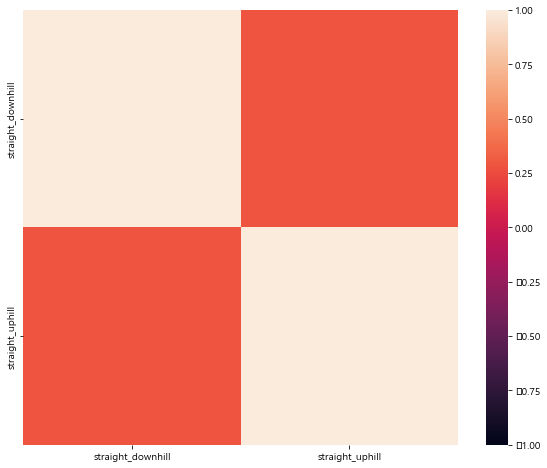

In [67]:
heatmap_data = final_df[['straight_downhill','straight_uphill']]
plt.figure(figsize=(10,8))
sns.heatmap(heatmap_data.astype(float).corr(), vmax=1.0, vmin=-1.0, square = True, linecolor = 'white')

<AxesSubplot:>

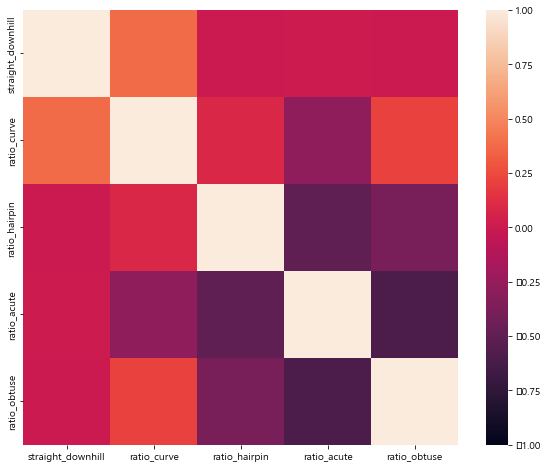

In [68]:
heatmap_data = final_df[['straight_downhill','ratio_curve', 'ratio_hairpin', 'ratio_acute', 'ratio_obtuse']]
plt.figure(figsize=(10,8))
sns.heatmap(heatmap_data.astype(float).corr(), vmax=1.0, vmin=-1.0, square = True, linecolor = 'white')

<AxesSubplot:>

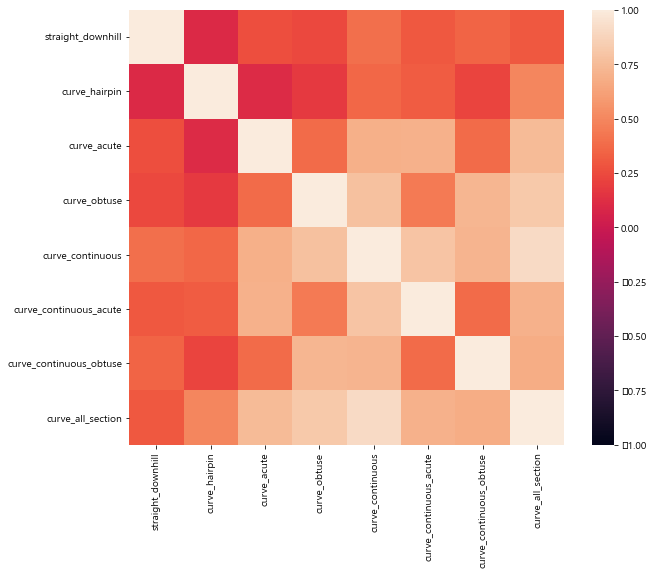

In [69]:
heatmap_data = final_df[['straight_downhill','curve_hairpin', 'curve_acute',
       'curve_obtuse', 'curve_continuous', 'curve_continuous_acute',
       'curve_continuous_obtuse', 'curve_all_section']]
plt.figure(figsize=(10,8))
sns.heatmap(heatmap_data.astype(float).corr(), vmax=1.0, vmin=-1.0, square = True, linecolor = 'white')